**Real-world Bandit Problem**

How often does someone write a feedback after an order?

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

stationary=True
class Bandit():
  def __init__(self, user_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple users are created. The probability of each user
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.user_count = user_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.user_count)
  
  def get_reward_regret(self, user):
    """ Returns random reward for user action. Assumes actions are 0-indexed
    Args:
      user is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.user_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[user]
    regret = self.thetas.max() - self.thetas[user]
    
    return reward, regret

In [41]:
class BetaAlgo():
  """
  The algos try to learn which Bandit user is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit users with a Beta, 
  assuming the true probability of success of an user is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.user_count = bandit.user_count
    self.alpha = np.ones(self.user_count)
    self.beta = np.ones(self.user_count)
  
  def get_reward_regret(self, user):
    reward, regret = self.bandit.get_reward_regret(user)
    self._update_params(user, reward)
    return reward, regret
  
  def _update_params(self, user, reward):
    self.alpha[user] += reward
    self.beta[user] += 1 - reward

class BernGreedy(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)
  
  @staticmethod
  def name():
    return 'beta-greedy'
   
  def get_action(self):
    """ Bernouilli parameters are the expected values of the beta"""
    theta = self.alpha / (self.alpha + self.beta)
    return theta.argmax()

class BernThompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.beta(self.alpha, self.beta)
    return theta.argmax()

In [42]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.user_count = bandit.user_count
    self.Q = np.zeros(self.user_count) # q-value of actions
    self.N = np.zeros(self.user_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.user_count)
    return action
  
  def get_reward_regret(self, user):
    reward, regret = self.bandit.get_reward_regret(user)
    self._update_params(user, reward)
    return reward, regret
  
  def _update_params(self, user, reward):
    self.N[user] += 1 # increment action count
    self.Q[user] += 1/self.N[user] * (reward - self.Q[user]) # inc. update rule

In [43]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.user_count = bandit.user_count
    self.Q = np.zeros(self.user_count) # q-value of actions
    self.N = np.zeros(self.user_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.user_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, user):
    reward, regret = self.bandit.get_reward_regret(user)
    self._update_params(user, reward)
    return reward, regret
  
  def _update_params(self, user, reward):
    self.N[user] += 1 # increment action count
    self.Q[user] += 1/self.N[user] * (reward - self.Q[user]) # inc. update rule

In [44]:
class RandomSampling():
  """
  Random Sampling
  """
  def __init__(self, bandit):
    self.bandit = bandit
    self.user_count = bandit.user_count
    self.Q = np.zeros(self.user_count) # q-value of actions
    self.N = np.zeros(self.user_count) + 0.0001 # action count
  
  @staticmethod
  def name():
    return 'random'
  
  def get_action(self):
    action = np.random.randint(0, self.user_count)
    return action
  
  def get_reward_regret(self, user):
    reward, regret = self.bandit.get_reward_regret(user)
    self._update_params(user, reward)
    return reward, regret
  
  def _update_params(self, user, reward):
    self.N[user] += 1 # increment action count
    self.Q[user] += 1/self.N[user] * (reward - self.Q[user]) # inc. update rule

In [85]:
class NormalThompson():
  def __init__(self, bandit):
    self.bandit = bandit
    self.user_count = bandit.user_count
    self.average = np.ones(self.user_count)
    self.value = np.zeros(self.user_count)
    self.record = []
    for i in range(0, self.user_count):
        self.record.append([1])
  
  @staticmethod
  def name():
    return 'normal-thompson'
  
  def get_action(self):
    theta = np.random.normal(self.average, self.value)
    return theta.argmax()
  
  def get_reward_regret(self, user):
    reward, regret = self.bandit.get_reward_regret(user)
    self._update_params(user, reward)
    return reward, regret
  
  def _update_params(self, user, reward):
    self.record[user] = np.append(self.record[user], reward)
    self.average[user] = self.record[user].mean()
    self.value[user] = self.record[user].var()

In [79]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, user_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(user_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(user_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, user_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

def experimentEpsilon(user_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, EpsilonGreedy, EpsilonGreedy, EpsilonGreedy, EpsilonGreedy]
  regrets = []
  names = []
  epsilons = [0.03, 0.05, 0.1, 0.3, 0.5]
  i = 0
  for algo in algos:    
    global epsilon
    epsilon = epsilons[i]
    i = i + 1
    regrets.append(simulate(simulations, timesteps, user_count, algo))
    names.append(algo.name() + str(epsilon))
  multi_plot_data(regrets, names)

def experimentUCB(user_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [UCB, UCB, UCB, UCB]
  regrets = []
  names = []
  ucbs = [0.1, 0.2, 0.5, 2]
  i = 0
  for algo in algos:    
    global ucb_c
    ucb_c = ucbs[i]
    i = i + 1
    regrets.append(simulate(simulations, timesteps, user_count, algo))
    names.append(algo.name() + str(ucb_c))
  multi_plot_data(regrets, names)

def experimentNormalThompson(user_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """
  algos = [EpsilonGreedy, UCB, BernThompson, RandomSampling, NormalThompson]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, user_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

**Which hyperparameters are important for Thompson Sampling, e-greedy, UCB, and random sampling?**

**Thompson Sampling**: No hyperparameter.

**E-greedy**: epsilon($\epsilon$). When the value of $\epsilon$ is large, the e-greedy curve converges fast, but its performance is slightly worse. When the value of $\epsilon$ becomes small, the e-greedy curve converges slow, but the performance will be a little bit better than previous.

**UCB**: ucb_c($c$). When the value of ($c$) is lower, the influence on ($Q$) is smaller, the speed of ucb curve stability is faster, and there is not much difference in convergence speed. On the contrary, the influence on ($Q$) becomes larger, the time required for stabilization becomes longer, and the final optimization effect is slightly worse.

**Random Sampling**: No hyperarameter.


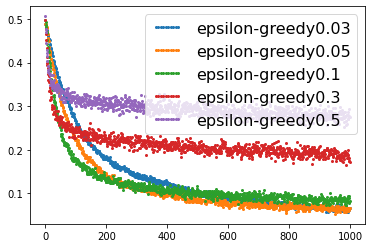

In [66]:
# Experiment e-greedy
user_count = 200 # number of users in bandit
epsilon = 0.01
ucb_c = 2
stationary=True
experimentEpsilon(user_count)

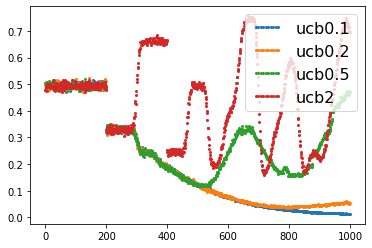

In [72]:
# Experiment ucb
user_count = 200 # number of users in bandit
epsilon = 0.01
ucb_c = 2
stationary=True
experimentUCB(user_count)

**How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling?**

**Thompson Sampling**: More action space makes the convergence speed of Thompson sampling slower, but the regret value will be lower, indicating that Thompson sampling is still very reliable, but it takes longer to reach the ideal regret value. Thompson sampling is willing to explore unknown actions. Since there are so many actions, and since the mean rewards are evenly distributed between 0 and 1, there is a high cost of constantly exploring actions with rewards close to 0. Noticeably, the Thompson algorithm is incredibly stable across time, despite the large action space.

**E-greedy**: The greedy algorithm need only sample a few values and has a high probability of its most favourable action's estimated reward probability being close to the true optimal reward probability, ensuring it a low regret, even if it never chooses the optimal action.

**UCB**: UCB is also focus on exploring unknown actions, like Thompson Sampling. With different sampling nature, UCB is more likely choose those actions who are not the best. In other words, UCB is more likely to try some wrong actions. So it needs more time to select the best choice.

**Random Sampling**: No effect.

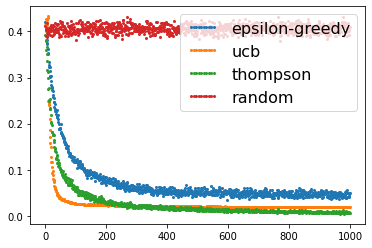

In [73]:
# Experiment small action space
arm_count = 10 # number of users in bandit
epsilon = 0.1
ucb_c = 0.1
stationary=True
experiment(arm_count)

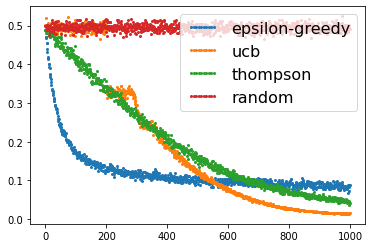

In [74]:
# Experiment large action space
arm_count = 200 # number of users in bandit
epsilon = 0.1
ucb_c = 0.1
stationary=True
experiment(arm_count)

**How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling?**

**Thompson Sampling**: Although Thompson Sampling converges quickly. But every time we change the reward distribution, we still have to start to converge again. The result each time is worse than before the change.

**E-greedy**: The e-greedy algorithm always tries to default the current choice as the best choice, and does not pay attention to the exploration process. When the reward changes over time, it cannot update the selected reward in time, so the result is very poor.

**UCB**: UCB reacts much more quickly to the non-stationarity, and actually continues to improve in regret over time. No doubt due to its higher emphasis on exploration.

**Random Sampling**: No effect.

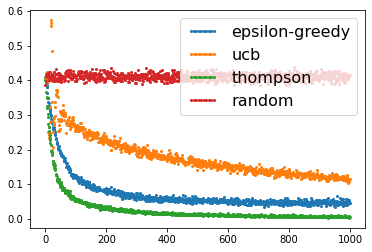

In [75]:
# Experiment stationary
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

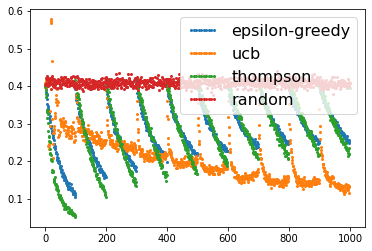

In [76]:
# Experiment non-stationary
arm_count = 10 # number of arms in bandit
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

**When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring?**

**Thompson Sampling**: If the action corresponding to the maximum value according to the beta distribution is not the last selected action. It begins exploring. If the action corresponding to the obtained maximum value is still the same action, Thompson Sampling stops exploring.

**E-greedy**: When the random value smaller than ($\epsilon$). It begins exploring. If the random value keep bigger than ($\epsilon$). E-greedy stops exploring.

**UCB**: If the upper boundary value of the current action is updated, the maximum upper boundary value (($Q$) value + confidence value) has changed. It begins exploring. After the update, the action with the maximum value of the upper boundary is still the original action. UCB stops exploring.

**Random Sampling**: Random sampling do not explore.

**How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions?**

**Thompson Sampling**: Thompson Sampling remembers the past actions from the beginning. It uses action result to generate beta distributions. And according to the beta distributions, select the next action which has the highest value. And keep doing this.

**E-greedy**: E-greedy also remembers the past actions from the beginning. It uses action result to change the ($Q$) value. And then it uses the action which has the biggest ($Q$) value.

**UCB**: UCB aslo remembers the past actions from the beginning. It calculates the confidence and updates the upper boundary value of current action. Then it select the next action with the biggest upper boundary value.

**Random Sampling**: Random sampling do not remember the past actions, it pick up action randomly each time.

**Thompson Sampling with non-Beta distribution.**

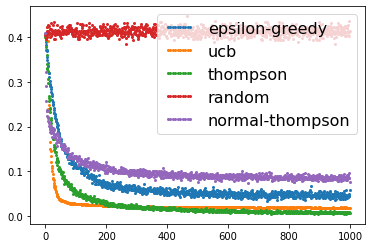

In [86]:
# Experiment small action space
arm_count = 10 # number of users in bandit
epsilon = 0.1
ucb_c = 0.1
stationary=True
experimentNormalThompson(arm_count)